<a href="https://colab.research.google.com/github/AlexanderLontke/ssl-remote-sensing/blob/main/notebooks/BiGAN_Resnet_Downstream_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Implementation Remote Sensing

## Import necessary packages

In [1]:
!pip install rasterio
!pip install wandb
!pip install lightning-bolts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.3 MB 8.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.4 MB/s 
     |████████████████████████████████| 168 kB 45.9 MB/s 
     |████████████████████████████████| 182 kB 56.6 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 166 kB 48.4 MB/s 
     |████████████████████████████████| 166 kB 63.4 MB/s 
     |████████████████████████████████| 162 kB 55.1 MB/s 
     |████████████████████████████████| 162 kB 60.1 MB/s 
     |████████████████████████████████| 158 kB 60.2 MB/s 
     |████████████████████████████████| 157 kB 58.9 MB/s 
     |████████████████████████████████| 157 kB 50.7 MB/s 
     |████████████████████████████████| 157 kB 61.6 MB/s 
     |████████████████████████████████| 157 kB 58.9

In [2]:
# import standard python libraries
import os
import datetime as time
from datetime import datetime
import numpy as np
import pickle as pkl
import glob
from pathlib import Path
from math import floor
import random
from itertools import chain
from typing import List, Any
import functools

# import data reader, logging and transforms
from torchvision import transforms
from torchvision import datasets
import torchvision
from tqdm import tqdm
import tarfile
import rasterio as rio

# import the PyTorch deep learning library
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.utils.data import (
    Dataset,
    DataLoader,
    random_split,
    Subset,
    SubsetRandomSampler,
)
import torch.utils.model_zoo as model_zoo
import torchvision.utils as vutils
from torch.autograd import Variable
from torchsummary import summary
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pl_bolts.callbacks import (
    LatentDimInterpolator,
    TensorboardGenerativeModelImageSampler,
)
from sklearn.metrics import classification_report
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import cv2
from albumentations.pytorch import ToTensorV2
import albumentations as A

# import matplotlib and enabling notebook inline plotting:
import matplotlib.pyplot as plt

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:35: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.7/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:93: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapContr

Mount Google Drive Directories for data access

In [3]:
# import the Google Colab GDrive connector
from google.colab import drive
import gdown

# mount GDrive inside the Colab notebook
drive.mount("/content/drive")

/usr/local/lib/python3.7/dist-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


Mounted at /content/drive


In [4]:
# create Colab Notebooks directory
notebook_directory = Path("/content/drive/MyDrive/Projects/DeepLearning")
if not os.path.exists(notebook_directory):
    os.makedirs(notebook_directory)

# create data sub-directory inside the Colab Notebooks directory
data_directory = Path("/content/drive/MyDrive/Projects/DeepLearning/data")
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

# create models sub-directory inside the Colab Notebooks directory
models_directory = Path("/content/drive/MyDrive/Projects/DeepLearning/models")
if not os.path.exists(models_directory):
    os.makedirs(models_directory)

# checkpoint directory
chkpt_directory = Path("/content/drive/MyDrive/Projects/DeepLearning/checkpoints")
if not os.path.exists(chkpt_directory):
    os.makedirs(chkpt_directory)

## Helper Functions

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu").type

print("[LOG] notebook with {} computation enabled".format(str(device)))

[LOG] notebook with cuda computation enabled


In [6]:
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
if device == "cuda":
    torch.cuda.manual_seed(SEED)

## Data

Define the directory on your drive to reproduce results. Downloaded data from https://madm.dfki.de/files/sentinel/EuroSATallBands.zip should be within the data folder created in previous steps. 

In [7]:
gdown.download(
    "https://drive.google.com/u/1/uc?id=1zGalZSCxgnmZM7zMm0qfRrnOXyD6IUX1&export=download"
)

Downloading...
From: https://drive.google.com/u/1/uc?id=1zGalZSCxgnmZM7zMm0qfRrnOXyD6IUX1&export=download
To: /content/lab-seg-data.tar.gz
100%|██████████| 5.37G/5.37G [00:57<00:00, 93.9MB/s]


'lab-seg-data.tar.gz'

In [8]:
data_base_path = "/content/"
data_folder = "lab-seg-data"
tar_path = os.path.join(data_base_path, data_folder + ".tar.gz")

with tarfile.open(tar_path, mode="r") as tar:
    tar.extractall(path=data_base_path)

In [9]:
class SEN12FLOODS:
    """SEN12FLOODS Segmentation Dataset."""

    def __init__(self, root="chips/", split="train", transforms=None, **kwargs):
        super(SEN12FLOODS, self).__init__()

        # Loop over available data and create pairs of Sentinel 1 and Sentinel 2 images, co-registered,
        # with corresponding groundtruth, and store the paths in lists.
        (
            self.s2_images,
            self.s2_masks,
            self.s1_images,
            self.s1_masks,
        ) = self._get_sen2flood_pairs(root, split)

        # Make sure that for each data point we have all the values we need.
        assert (
            len(self.s2_images)
            == len(self.s2_masks)
            == len(self.s1_images)
            == len(self.s1_masks)
        )
        if len(self.s2_images) == 0:
            raise RuntimeError("Found 0 images in subfolders of:" + root + "\n")

        print(
            "Found {} images in the folder {}".format(len(self.s2_images), root + split)
        )

        self.transforms = transforms

        # Initialise the data augmentation we will use: horizontal and vertical flipping, random affine translation, resizing
        if self.transforms:
            augmentation = A.Compose(
                [
                    A.Resize(
                        height=256, width=256, p=1, interpolation=cv2.INTER_NEAREST
                    ),
                    A.Affine(scale=2, translate_px=5, rotate=20, p=0.5),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    ToTensorV2(),
                ],
                additional_targets={"image0": "image"},
            )
            self.augmentation = augmentation

        else:
            augmentation = A.Compose(
                [
                    A.Resize(
                        height=256, width=256, p=1, interpolation=cv2.INTER_NEAREST
                    ),
                    ToTensorV2(),
                ],
                additional_targets={"image0": "image"},
            )
            self.augmentation = augmentation

        # turn lists into arrays
        self.s2_images = np.array(self.s2_images)
        self.s1_images = np.array(self.s1_images)
        self.s2_masks = np.array(self.s2_masks)
        self.s1_masks = np.array(self.s1_masks)

    def __len__(self):
        return len(self.s2_images)

    def __getitem__(self, index):
        # Loop over all bands, and create a concatenated array for sentinel-2 data
        bands = []
        for file in [
            "B1.tif",
            "B2.tif",
            "B3.tif",
            "B4.tif",
            "B5.tif",
            "B6.tif",
            "B7.tif",
            "B8.tif",
            "B8A.tif",
            "B9.tif",
            "B10.tif",
            "B11.tif",
            "B12.tif",
        ]:
            band = rio.open(os.path.join(self.s2_images[index], file))
            bands.append(band.read())
        s2_img = np.concatenate(bands, axis=0)
        s2_img = np.array(s2_img, dtype=np.float32)
        # print(s2_img.shape)

        # Loop over both polarization, and create a concatenated array for sentinel-1 data
        bands = []
        for file in ["VH.tif", "VV.tif"]:
            band = rio.open(os.path.join(self.s1_images[index], file))
            band_array = band.read()
            if np.isfinite(band_array).all():
                bands.append(band.read())
            else:
                bands.append(np.zeros(band_array.shape))
        s1_img = np.concatenate(bands, axis=0)
        s1_img = np.array(s1_img, dtype=np.float32)

        # The two channels of Sentinel-1 (VV and VH) have both negative and positive values.
        # We normalize them to lie between 0 and 1 by applying [min-max normalization with min = -77 and max = 26.
        s1_img = np.clip(s1_img, a_min=-77, a_max=26)
        s1_img = (s1_img + 77) / (26 + 77)

        # The water labels for Sentinel 1 and Sentinel 2 can be slightly different (since scenes are taken around 3 days apart)
        # We read the water label mask associated to Sentinel 2.
        mask = rio.open(self.s2_masks[index])
        mask_img = mask.read().squeeze()

        # Apply same data augmentation for both sentinel 2 and sentinel 1 images, and the mask.
        augmented_data = self.augmentation(
            image=np.transpose(s2_img, (1, 2, 0)),
            image0=np.transpose(s1_img, (1, 2, 0)),
            mask=mask_img,
        )

        # Define output tensor
        output_tensor = {
            "s2_img": augmented_data["image"],
            "s1_img": augmented_data["image0"],
            "s2_imgfile": self.s2_images[index],
            "s1_imgfile": self.s1_images[index],
            "mask": augmented_data["mask"],
            # "mask": np.expand_dims(augmented_data['mask'], axis=0),
        }

        return output_tensor

    def _get_sen2flood_pairs(self, folder, split):
        """
        Constructs Sentinel2 and Sentinel1 pairs

        Arguments
        ----------
            folder : str
                Image folder name
            split : str
                train or val split
        Returns
        -------
            s2_img_paths : list
                List of Sentinel 2 image path
            s2_mask_paths : list
                List of Sentinel 2 water mask path
            s1_img_paths : list
                List of Sentinel 1 image path
            s1_mask_paths : list
                List of Sentinel 1 water mask path
        """
        s2_img_paths = []
        s2_mask_paths = []
        s1_img_paths = []
        s1_mask_paths = []

        img_folder = os.path.join(folder, split)

        # loop over the image folder (train or validation)
        for filename in os.listdir(img_folder):
            if filename not in ["._.DS_Store", ".DS_Store"]:
                for file in os.listdir(os.path.join(img_folder, filename, "s2")):
                    if file not in ["._.DS_Store", ".DS_Store"]:
                        # Get the Image ID (as explained in the dataset section)
                        image_id = file.split("_")[-1]

                        # Store Sentinel 2 image and mask paths in lists
                        s2_imgpath = os.path.join(img_folder, filename, "s2", file)
                        s2_maskpath = os.path.join(
                            img_folder, filename, "s2", file, "LabelWater.tif"
                        )

                        # Using the Image ID, store co-registered Sentinel 1 image and mask paths in lists
                        s1_files = os.listdir(os.path.join(img_folder, filename, "s1"))
                        s1_file = [
                            file for file in s1_files if file.endswith(image_id)
                        ][0]
                        s1_imgpath = os.path.join(img_folder, filename, "s1", s1_file)
                        s1_maskpath = os.path.join(
                            img_folder, filename, "s1", s1_file, "LabelWater.tif"
                        )

                        if os.path.isfile(s1_maskpath):
                            s2_img_paths.append(s2_imgpath)
                            s2_mask_paths.append(s2_maskpath)
                            s1_img_paths.append(s1_imgpath)
                            s1_mask_paths.append(s1_maskpath)
                        else:
                            print("cannot find the S1 Mask:", s1_maskpath)

        return s2_img_paths, s2_mask_paths, s1_img_paths, s1_mask_paths

    def visualize_observation(self, idx):
        """
        Visualise Sentinel1, Sentinel2, and water mask.

        Arguments
        ----------
            idx : int
                Data index
        """
        sample = self.__getitem__(idx)

        s2_image = sample.get("s2_img").squeeze()
        s1_image = sample.get("s1_img").squeeze()
        mask = sample.get("mask")

        print(sample.get("s2_imgfile"))
        print(sample.get("s1_imgfile"))

        fig, axs = plt.subplots(1, 3, figsize=(17, 6))

        s1_img_vh = s1_image[0, :, :]
        s1_img_vh = s1_img_vh / s1_img_vh.max()

        axs[0].imshow(s1_img_vh)
        axs[0].set_title("Sentinel-1 VH")
        axs[0].axis("off")

        s2_img_rgb = s2_image[[3, 2, 1], :, :]
        s2_img_rgb = np.transpose(s2_img_rgb, (1, 2, 0))
        s2_img_rgb = s2_img_rgb / s2_img_rgb.max()

        axs[1].imshow(s2_img_rgb)
        axs[1].set_title("Sentinel-2 RGB")
        axs[1].axis("off")

        mask = mask.squeeze()

        axs[2].imshow(mask, cmap="Blues")
        axs[2].set_title("Groundtruth Mask")
        axs[2].axis("off")

        plt.show()

In [10]:
trainset = SEN12FLOODS(root="/content/chips/", transforms=True, split="train")

valset = SEN12FLOODS(root="/content/chips/", split="val")


train_loader = DataLoader(trainset, batch_size=32, pin_memory=True)

val_loader = DataLoader(valset, batch_size=32, pin_memory=True)

Found 688 images in the folder /content/chips/train
Found 211 images in the folder /content/chips/val


In [11]:
next(iter(train_loader))["mask"].shape

torch.Size([32, 256, 256])

In [12]:
next(iter(train_loader))["s2_img"].shape

torch.Size([32, 13, 256, 256])

/content/chips/train/e7d1917e-c069-45cf-a392-42e24aa2f4ac/s2/S2A_MSIL1C_20201022T100051_N0209_R122_T33UXP_20201022T111023_06656-07168
/content/chips/train/e7d1917e-c069-45cf-a392-42e24aa2f4ac/s1/S1B_IW_GRDH_1SDV_20201020T164222_20201020T164247_023899_02D6C4_35D8_06656-07168


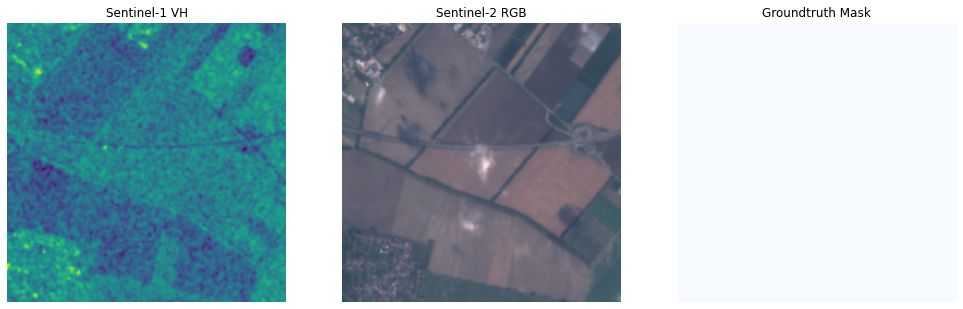

In [13]:
trainset.visualize_observation(5)

In [14]:
def best_model_loader(pretext_model, pretext_model_dir, pretext_model_path):

    # restore pre-trained model snapshot
    best_model_name = os.path.join(pretext_model_dir, pretext_model_path)

    # load state_dict from path
    state_dict_best = torch.load(best_model_name, map_location=torch.device("cpu"))

    # init pre-trained model class
    best_model = pretext_model

    # load pre-trained models
    best_model.load_state_dict(state_dict_best)

    return best_model

In [15]:
# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [16]:
__all__ = [
    "ResNet",
    "resnet18",
    "resnet34",
    "resnet50",
    "resnet101",
    "resnet152",
    "resnext50_32x4d",
    "resnext101_32x8d",
]


model_urls = {
    "resnet18": "https://download.pytorch.org/models/resnet18-5c106cde.pth",
    "resnet34": "https://download.pytorch.org/models/resnet34-333f7ec4.pth",
    "resnet50": "https://download.pytorch.org/models/resnet50-19c8e357.pth",
    "resnet101": "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth",
    "resnet152": "https://download.pytorch.org/models/resnet152-b121ed2d.pth",
}


class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x


def conv3x3(in_planes, out_planes, stride=1, groups=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=1,
        groups=groups,
        bias=False,
    )


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        norm_layer=None,
        dropout=0,
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if dropout > 0:
            drop_layer = functools.partial(nn.Dropout2d, p=dropout)
        else:
            drop_layer = Identity
        if groups != 1:
            raise ValueError("BasicBlock only supports groups=1")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.drop1 = drop_layer()
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.drop2 = drop_layer()
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.drop1(out)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.drop2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(
        self,
        inplanes,
        planes,
        stride=1,
        downsample=None,
        groups=1,
        norm_layer=None,
        dropout=0,
    ):
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if dropout > 0:
            drop_layer = functools.partial(nn.Dropout2d, p=dropout)
        else:
            drop_layer = IdentityMapping
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = norm_layer(planes)
        self.conv2 = conv3x3(planes, planes, stride, groups)
        self.drop2 = drop_layer()
        self.bn2 = norm_layer(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.drop3 = drop_layer()
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.drop2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.drop3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [17]:
class ResNet(nn.Module):
    def __init__(
        self,
        block,
        layers,
        num_classes=1000,
        zero_init_residual=False,
        groups=1,
        width_per_group=64,
        norm_layer=None,
        dropout=0.0,
    ):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        planes = [int(width_per_group * groups * 2**i) for i in range(4)]
        self.inplanes = planes[0]
        self.conv1 = nn.Conv2d(
            3, planes[0], kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = norm_layer(planes[0])
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(
            block,
            planes[0],
            layers[0],
            groups=groups,
            norm_layer=norm_layer,
            dropout=dropout,
        )
        self.layer2 = self._make_layer(
            block,
            planes[1],
            layers[1],
            stride=2,
            groups=groups,
            norm_layer=norm_layer,
            dropout=dropout,
        )
        self.layer3 = self._make_layer(
            block,
            planes[2],
            layers[2],
            stride=2,
            groups=groups,
            norm_layer=norm_layer,
            dropout=dropout,
        )
        self.layer4 = self._make_layer(
            block,
            planes[3],
            layers[3],
            stride=2,
            groups=groups,
            norm_layer=norm_layer,
            dropout=dropout,
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(planes[3] * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(
        self, block, planes, blocks, stride=1, groups=1, norm_layer=None, dropout=0.0
    ):
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                groups,
                norm_layer,
                dropout=dropout,
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=groups,
                    norm_layer=norm_layer,
                    dropout=dropout,
                )
            )

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        # x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def param_without_bn(self):
        param_list = []
        for p in self.named_parameters():
            if "bn" in p[0]:
                pass
            else:
                param_list.append(p[1])
        return param_list

    def param_layerx(self, layer_up_to=1):
        param_list = []
        for p in self.named_parameters():
            if "bn" in p[0]:
                pass
            elif p[0].startswith("conv") or (
                ("layer" in p[0]) and int(p[0][5]) <= layer_up_to
            ):
                param_list.append(p[1])
        return param_list

In [18]:
def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls["resnet18"]))
    return model

In [19]:
resnet_basemodel = resnet18(True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [20]:
resnet_basemodel.fc = nn.Sequential()

In [21]:
summary(resnet_basemodel.to("cuda"), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
          Identity-6           [-1, 64, 16, 16]               0
       BatchNorm2d-7           [-1, 64, 16, 16]             128
              ReLU-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          36,864
         Identity-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
       BasicBlock-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

In [22]:
class ResnetGenerator(nn.Module):
    def __init__(
        self,
        latent_dim: int,
        feature_maps: int,
        image_channels: int,
        pretrained_model: nn.Module,
    ) -> None:
        super(ResnetGenerator, self).__init__()
        # input dim: 100 x 1 x 1
        self.noise_init = nn.Sequential(
            self._make_gen_block(
                latent_dim, feature_maps * 8, kernel_size=4, stride=1, padding=0
            ),
            self._make_gen_block(feature_maps * 8, feature_maps * 4),
            self._make_gen_block(feature_maps * 4, feature_maps * 2),
            self._make_gen_block(feature_maps * 2, feature_maps),
            self._make_gen_block(feature_maps, image_channels, last_block=True),
        )
        # input dim: 3 x 64 x 64
        self.pretrained_model = pretrained_model
        # input dim: 512 x 1 x 1
        self.gen = nn.Sequential(
            self._make_gen_block(
                feature_maps * 8, feature_maps * 8, kernel_size=4, stride=1, padding=0
            ),
            self._make_gen_block(feature_maps * 8, feature_maps * 4),
            self._make_gen_block(feature_maps * 4, feature_maps * 2),
            self._make_gen_block(feature_maps * 2, feature_maps),
            self._make_gen_block(feature_maps, image_channels, last_block=True),
        )
        # output dim: 3 x 64 x 64

        self.noise_init.apply(self._weights_init)
        self.gen.apply(self._weights_init)

    @staticmethod
    def _make_gen_block(
        in_channels: int,
        out_channels: int,
        kernel_size: int = 4,
        stride: int = 2,
        padding: int = 1,
        bias: bool = False,
        last_block: bool = False,
    ) -> nn.Sequential:
        if not last_block:
            gen_block = nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels, out_channels, kernel_size, stride, padding, bias=bias
                ),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(True),
            )
        else:
            gen_block = nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels, out_channels, kernel_size, stride, padding, bias=bias
                ),
                nn.Tanh(),
            )
        return gen_block

    @staticmethod
    def _make_enc_block(
        in_channels: int,
        out_channels: int,
        kernel_size: int = 4,
        stride: int = 2,
        padding: int = 1,
        bias: bool = False,
        last_block: bool = False,
    ) -> nn.Sequential:
        if not last_block:
            enc_block = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size, stride, padding, bias=bias
                ),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(True),
            )
        else:
            enc_block = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size, stride, padding, bias=bias
                ),
                nn.Tanh(),
            )

        return enc_block

    @staticmethod
    def _weights_init(m):
        classname = m.__class__.__name__
        if classname.find("Conv") != -1:
            nn.init.normal_(m.weight, 0.0, 0.02)
        elif classname.find("BatchNorm") != -1:
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.zeros_(m.bias)

    def forward(self, x: Tensor) -> Tensor:
        x = self.noise_init(x)
        x = self.pretrained_model(x)
        x = self.gen(x)
        return x

In [23]:
generator = ResnetGenerator(100, 64, 3, resnet_basemodel).to("cuda")

In [24]:
summary(generator.to("cuda"), (100, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [25]:
class ResnetEncoder(nn.Module):
    def __init__(
        self,
        latent_dim: int,
        feature_maps: int,
        image_channels: int,
        pretrained_model: nn.Module,
    ) -> None:
        super(ResnetEncoder, self).__init__()
        # input dim: 3 x 64 x 64
        self.pretrained_model = pretrained_model
        self.enc = nn.Sequential(nn.Linear(512, 100))

        self.enc.apply(self._weights_init)

    @staticmethod
    def _make_enc_block(
        in_channels: int,
        out_channels: int,
        kernel_size: int = 4,
        stride: int = 2,
        padding: int = 1,
        bias: bool = False,
        last_block: bool = False,
    ) -> nn.Sequential:
        if not last_block:
            enc_block = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size, stride, padding, bias=bias
                ),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(True),
            )
        else:
            enc_block = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size, stride, padding, bias=bias
                ),
                nn.Tanh(),
            )

        return enc_block

    @staticmethod
    def _weights_init(m):
        classname = m.__class__.__name__
        if classname.find("Conv") != -1:
            nn.init.normal_(m.weight, 0.0, 0.02)
        elif classname.find("BatchNorm") != -1:
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.zeros_(m.bias)

    def forward(self, x: Tensor) -> Tensor:
        x = self.pretrained_model(x)
        x = x.view(x.size(0), -1)
        x = self.enc(x)
        x = x.unsqueeze(2).unsqueeze(3)
        return x

In [26]:
encoder = ResnetEncoder(100, 64, 3, resnet_basemodel).to("cuda")

In [27]:
summary(encoder, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
          Identity-6           [-1, 64, 16, 16]               0
       BatchNorm2d-7           [-1, 64, 16, 16]             128
              ReLU-8           [-1, 64, 16, 16]               0
            Conv2d-9           [-1, 64, 16, 16]          36,864
         Identity-10           [-1, 64, 16, 16]               0
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
       BasicBlock-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

In [28]:
class Discriminator(nn.Module):
    def __init__(self, latent_dim: int, feature_maps: int, image_channels: int) -> None:
        super().__init__()

        self.disc_x = nn.Sequential(
            self._make_disc_block(image_channels, feature_maps, batch_norm=False),
            self._make_disc_block(feature_maps, feature_maps * 2),
            self._make_disc_block(feature_maps * 2, feature_maps * 4),
            self._make_disc_block(feature_maps * 4, feature_maps * 8),
            self._make_disc_block(
                feature_maps * 8,
                feature_maps * 8,
                kernel_size=4,
                stride=1,
                padding=0,
                last_block=True,
            ),
        )

        self.disc_z = nn.Sequential(
            nn.Conv2d(
                latent_dim, feature_maps * 8, kernel_size=1, stride=1, bias=False
            ),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Dropout2d(0.2),
            nn.Conv2d(
                feature_maps * 8, feature_maps * 8, kernel_size=1, stride=1, bias=False
            ),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Dropout2d(0.2),
        )

        self.disc_joint = nn.Sequential(
            nn.Conv2d(
                feature_maps * 16,
                feature_maps * 16,
                kernel_size=1,
                stride=1,
                bias=False,
            ),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Dropout(0.2),
            nn.Conv2d(
                feature_maps * 16,
                feature_maps * 16,
                kernel_size=1,
                stride=1,
                bias=False,
            ),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Dropout2d(0.2),
            nn.Conv2d(feature_maps * 16, 1, kernel_size=1, stride=1, bias=False),
        )

    @staticmethod
    def _make_disc_block(
        in_channels: int,
        out_channels: int,
        kernel_size: int = 4,
        stride: int = 2,
        padding: int = 1,
        bias: bool = False,
        batch_norm: bool = True,
        last_block: bool = False,
    ) -> nn.Sequential:
        if not last_block:
            disc_block = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size, stride, padding, bias=bias
                ),
                nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            disc_block = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels, kernel_size, stride, padding, bias=bias
                ),
            )

        return disc_block

    def forward(self, x: Tensor, z: Tensor) -> Tensor:
        x = self.disc_x(x)
        z = self.disc_z(z)
        joint = torch.cat((x, z), dim=1)
        out = self.disc_joint(joint)
        return torch.sigmoid(out)

## BiGAN

In [29]:
from typing import Any

In [30]:
class BIGAN(LightningModule):
    def __init__(
        self,
        beta1: float = 0.5,
        feature_maps_gen: int = 64,
        feature_maps_disc: int = 64,
        feature_maps_enc: int = 64,
        image_channels: int = 3,
        latent_dim: int = 100,
        learning_rate: float = 0.0002,
        **kwargs: Any,
    ) -> None:

        super().__init__()
        self.beta1 = beta1
        self.feature_maps_gen = feature_maps_gen
        self.feature_maps_disc = feature_maps_disc
        self.feature_maps_enc = feature_maps_enc
        self.image_channels = image_channels
        self.latent_dim = latent_dim
        self.learning_rate = learning_rate

        self.generator = self._get_generator()
        self.discriminator = self._get_discriminator()
        self.encoder = self._get_encoder()

        self.criterion = nn.BCELoss()

    def _get_generator(self) -> nn.Module:
        generator = ResnetGenerator(
            self.latent_dim,
            self.feature_maps_gen,
            self.image_channels,
            pretrained_model=resnet_basemodel,
        )
        return generator

    def _get_discriminator(self) -> nn.Module:
        discriminator = Discriminator(
            self.latent_dim, self.feature_maps_disc, self.image_channels
        )
        discriminator.apply(self._weights_init)
        return discriminator

    def _get_encoder(self) -> nn.Module:
        encoder = ResnetEncoder(
            self.latent_dim,
            self.feature_maps_enc,
            self.image_channels,
            pretrained_model=resnet_basemodel,
        )
        return encoder

    @staticmethod
    def _weights_init(m):
        classname = m.__class__.__name__
        if classname.find("Conv") != -1:
            nn.init.normal_(m.weight, 0.0, 0.02)
        elif classname.find("BatchNorm") != -1:
            nn.init.normal_(m.weight, 1.0, 0.02)
            nn.init.zeros_(m.bias)

    def configure_optimizers(self):
        lr = self.learning_rate
        betas = (self.beta1, 0.999)
        opt_disc = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=betas)
        opt_gen_enc = torch.optim.Adam(
            chain(self.generator.parameters(), self.encoder.parameters()),
            lr=lr,
            betas=betas,
        )
        return [opt_disc, opt_gen_enc], []

    def forward(self, noise: Tensor, x: Tensor):
        """Generates an image given input noise.
        Example::
            noise = torch.rand(batch_size, latent_dim)
            gan = GAN.load_from_checkpoint(PATH)
            img = gan(noise)
        """
        z_fake = Variable(
            torch.randn((batch_size, self.latent_dim, 1, 1)), requires_grad=False
        ).to(self.device)
        x_fake = self.generator(z_fake)

        x_true = x.float()
        z_true = self.encoder(x_true)

        return (
            x_true,
            z_true,
            x_fake,
            z_fake,
        )

    def training_step(self, batch, batch_idx, optimizer_idx):
        x, _ = batch

        z_fake = Variable(
            torch.randn((batch_size, self.latent_dim, 1, 1)), requires_grad=False
        ).to(self.device)
        x_fake = self.generator(z_fake)

        x_true = x.float()
        z_true = self.encoder(x_true)

        # Train discriminator
        result = None
        if optimizer_idx == 0:
            result = self._disc_step(x_true, z_true, x_fake, z_fake)

        # Train generator
        if optimizer_idx == 1:
            result = self._gen_enc_step(x_true, z_true, x_fake, z_fake)

        return result

    def _disc_step(
        self, x_true: Tensor, z_true: Tensor, x_fake: Tensor, z_fake: Tensor
    ) -> Tensor:
        disc_loss = self._get_disc_loss(x_true, z_true, x_fake, z_fake)
        self.log("loss/disc", disc_loss, on_epoch=True)
        return disc_loss

    def _gen_enc_step(
        self, x_true: Tensor, z_true: Tensor, x_fake: Tensor, z_fake: Tensor
    ) -> Tensor:
        gen_enc_loss = self._get_gen_enc_loss(x_true, z_true, x_fake, z_fake)
        self.log("loss/gen_enc", gen_enc_loss, on_epoch=True)
        return gen_enc_loss

    def _get_disc_loss(
        self, x_true: Tensor, z_true: Tensor, x_fake: Tensor, z_fake: Tensor
    ) -> Tensor:
        # Train with real
        out_true = self.discriminator(x_true, z_true)
        y_true = torch.ones_like(out_true)
        real_loss = self.criterion(out_true, y_true)

        # Train with fake
        out_fake = self.discriminator(x_fake, z_fake)
        y_fake = torch.zeros_like(out_fake)
        fake_loss = self.criterion(out_fake, y_fake)

        disc_loss = real_loss + fake_loss

        return disc_loss

    def _get_gen_enc_loss(
        self, x_true: Tensor, z_true: Tensor, x_fake: Tensor, z_fake: Tensor
    ) -> Tensor:
        # Train with real
        out_true = self.discriminator(x_true, z_true)
        y_fake = torch.zeros_like(out_true)
        real_loss = self.criterion(out_true, y_fake)

        # Train with fake
        out_fake = self.discriminator(x_fake, z_fake)
        y_true = torch.ones_like(out_fake)
        fake_loss = self.criterion(out_fake, y_true)

        gen_enc_loss = real_loss + fake_loss

        return gen_enc_loss

    def _get_noise(self, n_samples: int, latent_dim: int) -> Tensor:
        return torch.randn(n_samples, latent_dim, device=self.device)

    def on_validation_epoch_end(self):
        z = Variable(torch.randn((5, self.latent_dim, 1, 1)), requires_grad=False)

        # log sampled images
        sample_imgs = self.generator(z)
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image("generated_images", grid, self.current_epoch)

# Different Approach 

https://github.com/MStypulkowski/BiGAN/blob/master/BiGAN.ipynb

In [31]:
n_epochs = 100  # number of training epochs
batch_size = 2000  # size of the mini-batches

In [32]:
model = BIGAN()

In [33]:
trainer = Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    log_every_n_steps=10,
    check_val_every_n_epoch=10,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [34]:
trainer.fit(
    model,
    train_loader,
    ckpt_path=chkpt_directory.joinpath(
        "bigan_resnet_final_training_checkpoint_100.ckpt"
    ),
)

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Projects/DeepLearning/checkpoints/bigan_resnet_final_training_checkpoint_100.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/torch/optim/adam.py:90: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  super(Adam, self).__init__(params, defaults)
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type            | Params
--------------------------------------------------
0 | generator     | ResnetGenerator | 21.7 M
1 | discriminator | Discriminator   | 9.4 M 
2 | encoder       | ResnetEncoder   | 11.2 M
3 | criterion     | BCELoss         | 0     
--------------------------------------------------
31.1 M    Trainable params
0         Non-trainable params
31

In [35]:
best_model_encoder = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [36]:
from copy import deepcopy

bst_encoder = deepcopy(model.encoder)

In [37]:
# funciton to change first convolution layer input channels => make random kaiming normal initialization


def patch_first_conv(encoder, new_in_channels, default_in_channels=3):

    for module in encoder.modules():
        if isinstance(module, nn.Conv2d) and module.in_channels == 3:
            print("Module to be convoluted: ", module)
            break

    weight = module.weight.detach()
    module.in_channels = new_in_channels

    new_weight = torch.Tensor(
        module.out_channels, new_in_channels // module.groups, *module.kernel_size
    )
    for i in range(new_in_channels):
        new_weight[:, i] = weight[:, i % default_in_channels]

    new_weight = new_weight * (default_in_channels / new_in_channels)
    module.weight = nn.parameter.Parameter(new_weight)

    # make sure in_channel is changed
    assert module.in_channels == new_in_channels

In [38]:
patch_first_conv(bst_encoder, 13, default_in_channels=3)

Module to be convoluted:  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [39]:
temp = list(model.encoder.children())[0]

In [40]:
print(list(temp.children())[7])

Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (drop1): Identity()
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (drop2): Identity()
    (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (downsample): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): BasicBlock(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (drop1): Identity()
    (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stri

In [41]:
class ResNetUNet(nn.Module):
    def __init__(self, n_class, encoder=None):
        super().__init__()

        # test base mode: pretrained resnet 18 of imagenet
        # self.base_model = torchvision.models.resnet18(pretrained=True)
        # base model from our pre-trained model
        # patch_first_conv
        self.base_model = encoder
        self.base_layers = list(
            list(self.base_model.children())[0].children()
        )  # ATTENTION: CHANGE FOR GENERAL IMPLEMENTATION
        # self.base_layers = list(self.base_resnet.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])  # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(
            *self.base_layers[3:5]
        )  # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        # from 3 to 13
        self.conv_original_size0 = convrelu(13, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        # concat: skip connection to merge features from z_layer3
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        # concat: skip connection to merge features from z_layer2
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        # concat: skip connection to merge features from z_layer1
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [42]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

In [43]:
model_segmentation = ResNetUNet(1, encoder=bst_encoder)
# model_segmentation = ResNetUNet(1, encoder = best_model_encoder)

In [44]:
print(model_segmentation)

ResNetUNet(
  (base_model): ResnetEncoder(
    (pretrained_model): ResNet(
      (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (drop1): Identity()
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (drop2): Identity()
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_

In [45]:
summary(model_segmentation.to(device), (13, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           7,552
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
            Conv2d-5         [-1, 64, 128, 128]          40,768
            Conv2d-6         [-1, 64, 128, 128]          40,768
       BatchNorm2d-7         [-1, 64, 128, 128]             128
       BatchNorm2d-8         [-1, 64, 128, 128]             128
              ReLU-9         [-1, 64, 128, 128]               0
             ReLU-10         [-1, 64, 128, 128]               0
        MaxPool2d-11           [-1, 64, 64, 64]               0
        MaxPool2d-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          36,864
           Conv2d-14           [-1, 64,

In [46]:
# Define a learning rate
lr_segmentation = 0.0001

# Initialise the optimizer
optim_segmentation = torch.optim.Adam(
    model_segmentation.parameters(), lr=lr_segmentation
)

In [47]:
criterion_segmentation = torch.nn.BCEWithLogitsLoss().to(device)

In [48]:
if not os.path.exists("./weights"):
    os.mkdir("./weights")

In [49]:
from torchmetrics import JaccardIndex

num_epochs = 20

# Move the model to the GPU
model_segmentation.to(device)

# Create lists for logging losses and evaluation metrics:
train_losses = []
train_accs = []
train_ious = []

val_losses = []
val_accs = []
val_ious = []

# IoU
jaccard = JaccardIndex(num_classes=2).to(device)


# For every epoch
for epoch in range(num_epochs):
    epoch_loss = 0
    progress = tqdm(
        enumerate(train_loader), desc="Train Loss: ", total=len(train_loader)
    )

    # Specify you are in training mode
    model_segmentation.train()

    epoch_train_loss = 0
    epoch_val_loss = 0

    epoch_train_ious = 0
    epoch_val_ious = 0

    epoch_train_accs = 0
    epoch_val_accs = 0

    for i, batch in progress:
        # Transfer data to GPU if available
        data = batch["s2_img"].float().to(device)
        label = batch["mask"].float().to(device)

        # Make a forward pass
        output = model_segmentation(data)
        # print(output.shape)

        # Derive binary segmentation map from prediction
        output_binary = torch.zeros(output.shape)
        output_binary[output >= 0] = 1

        # Compute IoU
        epoch_train_ious += jaccard(output_binary.to(device), label.int()) / len(
            train_loader
        )

        # Compute pixel accuracies
        epoch_train_accs += torch.sum(output_binary.to(device) == label.int()) / (
            len(train_loader) * (256 * 256) * 100
        )

        # Compute the loss
        loss = criterion_segmentation(output, label.unsqueeze(1))

        # Clear the gradients
        optim_segmentation.zero_grad()

        # Calculate gradients
        loss.backward()

        # Update Weights
        optim_segmentation.step()

        # Accumulate the loss over the eopch
        epoch_train_loss += loss / len(train_loader)

        progress.set_description(
            "Epoch = {}, Train Loss: {:.4f}".format(epoch + 1, epoch_train_loss)
        )

    progress = tqdm(
        enumerate(val_loader),
        desc="val Loss: ",
        total=len(val_loader),
        position=0,
        leave=True,
    )

    # Specify you are in evaluation mode
    model_segmentation.eval()

    # Deactivate autograd engine (no backpropagation allowed)
    with torch.no_grad():
        epoch_val_loss = 0
        for j, batch in progress:
            # Transfer Data to GPU if available
            data = batch["s2_img"].float().to(device)
            label = batch["mask"].float().to(device)

            # Make a forward pass
            output = model_segmentation(data)

            # Derive binary segmentation map from prediction
            output_binary = torch.zeros(output.shape)
            output_binary[output >= 0] = 1

            # Compute IoU
            epoch_val_ious += jaccard(output_binary.to(device), label.int()) / len(
                val_loader
            )

            # Compute pixel accuracies
            epoch_val_accs += torch.sum(output_binary.to(device) == label.int()) / (
                len(val_loader) * (256 * 256) * 100
            )

            # Compute the loss
            val_loss = criterion_segmentation(output, label.unsqueeze(1))

            # Accumulate the loss over the epoch
            epoch_val_loss += val_loss / len(val_loader)

            progress.set_description("Validation Loss: {:.4f}".format(epoch_val_loss))

    if epoch == 0:
        best_val_loss = epoch_val_loss
    else:
        if epoch_val_loss <= best_val_loss:
            best_val_loss = epoch_val_loss
            # Save only the best model
            save_weights_path = "./weights/segmentation_model.pth"
            torch.save(model_segmentation.state_dict(), save_weights_path)
            print("Saving Model...")

    # print("Epoch = ", epoch+1)
    # Save losses in list, so that we can visualise them later.
    train_losses.append(epoch_train_loss.cpu().detach().numpy())
    val_losses.append(epoch_val_loss.cpu().detach().numpy())

    # Save IoUs in list, so that we can visualise them later.
    train_ious.append(epoch_train_ious.cpu().detach().numpy())
    val_ious.append(epoch_val_ious.cpu().detach().numpy())
    print(f"train_iou is {epoch_train_ious:.4f}, val_iou is {epoch_val_ious:.4f}")

    # Save accuracies in list, so that we can visualise them later.
    train_accs.append(epoch_train_accs.cpu().detach().numpy())
    val_accs.append(epoch_val_accs.cpu().detach().numpy())
    print(f"train_acc is {epoch_train_accs:.4f}, val_acc is {epoch_val_accs:.4f}")

print("Finished Training")

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
Validation Loss: 4.4023: 100%|██████████| 7/7 [00:28<00:00,  4.11s/it]


train_iou is 0.3743, val_iou is 0.4289
train_acc is 7.3893, val_acc is 8.0065


Validation Loss: 0.3200: 100%|██████████| 7/7 [00:27<00:00,  3.91s/it]


Saving Model...
train_iou is 0.6078, val_iou is 0.7706
train_acc is 8.4469, val_acc is 7.4203


Validation Loss: 0.2303: 100%|██████████| 7/7 [00:25<00:00,  3.69s/it]


Saving Model...
train_iou is 0.7406, val_iou is 0.8024
train_acc is 8.2776, val_acc is 7.1145


Validation Loss: 0.2163: 100%|██████████| 7/7 [00:25<00:00,  3.58s/it]


Saving Model...
train_iou is 0.7127, val_iou is 0.8018
train_acc is 8.2733, val_acc is 7.1164


Validation Loss: 0.2217: 100%|██████████| 7/7 [00:25<00:00,  3.62s/it]


train_iou is 0.7178, val_iou is 0.7968
train_acc is 8.2804, val_acc is 7.0740


Validation Loss: 0.2163: 100%|██████████| 7/7 [00:27<00:00,  3.90s/it]


train_iou is 0.7440, val_iou is 0.7965
train_acc is 8.2478, val_acc is 7.0620


Validation Loss: 0.1850: 100%|██████████| 7/7 [00:27<00:00,  3.92s/it]


Saving Model...
train_iou is 0.7705, val_iou is 0.7964
train_acc is 8.2382, val_acc is 7.1465


Validation Loss: 0.1647: 100%|██████████| 7/7 [00:27<00:00,  3.90s/it]


Saving Model...
train_iou is 0.7805, val_iou is 0.7997
train_acc is 8.2663, val_acc is 7.2828


Validation Loss: 0.1707: 100%|██████████| 7/7 [00:26<00:00,  3.76s/it]


train_iou is 0.7949, val_iou is 0.7915
train_acc is 8.2113, val_acc is 7.2038


Validation Loss: 0.1592: 100%|██████████| 7/7 [00:25<00:00,  3.71s/it]


Saving Model...
train_iou is 0.7852, val_iou is 0.7964
train_acc is 8.2403, val_acc is 7.2916


Validation Loss: 0.1522: 100%|██████████| 7/7 [00:25<00:00,  3.70s/it]


Saving Model...
train_iou is 0.8058, val_iou is 0.8079
train_acc is 8.2013, val_acc is 7.2590


Validation Loss: 0.1551: 100%|██████████| 7/7 [00:25<00:00,  3.63s/it]


train_iou is 0.7949, val_iou is 0.8003
train_acc is 8.2527, val_acc is 7.3081


Validation Loss: 0.1494: 100%|██████████| 7/7 [00:25<00:00,  3.67s/it]


Saving Model...
train_iou is 0.8134, val_iou is 0.8067
train_acc is 8.2689, val_acc is 7.2521


Validation Loss: 0.1423: 100%|██████████| 7/7 [00:25<00:00,  3.61s/it]


Saving Model...
train_iou is 0.8061, val_iou is 0.8151
train_acc is 8.2446, val_acc is 7.1951


Validation Loss: 0.1547: 100%|██████████| 7/7 [00:26<00:00,  3.75s/it]


train_iou is 0.8016, val_iou is 0.8022
train_acc is 8.2302, val_acc is 7.3485


Validation Loss: 0.1382: 100%|██████████| 7/7 [00:26<00:00,  3.84s/it]


Saving Model...
train_iou is 0.8267, val_iou is 0.8171
train_acc is 8.2716, val_acc is 7.2462


Validation Loss: 0.1407: 100%|██████████| 7/7 [00:26<00:00,  3.79s/it]


train_iou is 0.8218, val_iou is 0.8113
train_acc is 8.2803, val_acc is 7.2899


Validation Loss: 0.1312: 100%|██████████| 7/7 [00:26<00:00,  3.81s/it]


Saving Model...
train_iou is 0.8202, val_iou is 0.8236
train_acc is 8.2863, val_acc is 7.2229


Validation Loss: 0.1346: 100%|██████████| 7/7 [00:27<00:00,  3.97s/it]


train_iou is 0.8338, val_iou is 0.8177
train_acc is 8.2375, val_acc is 7.2851


Validation Loss: 0.1461: 100%|██████████| 7/7 [00:27<00:00,  3.97s/it]

train_iou is 0.8205, val_iou is 0.8143
train_acc is 8.2511, val_acc is 7.3361
Finished Training


In [50]:
from sklearn.metrics import confusion_matrix, accuracy_score, jaccard_score


def get_metrics(true, preds):
    matrix = confusion_matrix(true.flatten(), preds.flatten())
    class_0, class_1 = matrix.diagonal() / matrix.sum(axis=1)
    print("***************** Metrics *****************")
    print("Class 0 (no water) accuracy: {:.3f}".format(class_0))
    print("Class 1 (water) accuracy: {:.3f}".format(class_1))
    print(
        "Overall accuracy: {:.3f}".format(
            accuracy_score(true.flatten(), preds.flatten())
        )
    )
    print("Equally Weighted accuracy: {:.3f}".format(0.5 * class_0 + 0.5 * class_1))
    print("IoU: {:.3f}".format(jaccard_score(true.flatten(), preds.flatten())))
    print("*******************************************")

In [51]:
def display_outputs(idx=None, multi=False):
    # Pick a random index if none is specified
    if not idx:
        idx = random.randint(0, len(valset))
    print("Validation image ID: {}".format(idx))

    # Get Sentinel 2 and Sentinel 1 data
    s2_data = torch.unsqueeze(valset.__getitem__(idx)["s2_img"].float().to(device), 0)
    s1_data = torch.unsqueeze(valset.__getitem__(idx)["s1_img"].float().to(device), 0)

    # Get predictions from the model
    if multi:
        output = model_segmentation(s1_data, s2_data)
    else:
        output = model_segmentation(s2_data)

    # Threshold the output to generate the binary map (FYI: the threshold value "0" can be tuned as any other hyperparameter)
    output_binary = torch.zeros(output.shape)
    output_binary[output >= 0] = 1

    get_metrics(valset.__getitem__(idx)["mask"], output_binary)

    fig, axes = plt.subplots(1, 3, figsize=(15, 7))
    axes[0].imshow(
        np.transpose(valset.__getitem__(idx)["s2_img"][[3, 2, 1], :, :], (1, 2, 0))
        / valset.__getitem__(idx)["s2_img"].max()
    )
    axes[0].set_title("True Color Sentinel-2")
    axes[2].imshow(valset.__getitem__(idx)["mask"], cmap="Blues")
    axes[2].set_title("Groundtruth")
    axes[1].imshow(output_binary.squeeze(), cmap="Blues")
    axes[1].set_title("Predicted Mask")

Validation image ID: 43
***************** Metrics *****************
Class 0 (no water) accuracy: 0.998
Class 1 (water) accuracy: 0.605
Overall accuracy: 0.970
Equally Weighted accuracy: 0.802
IoU: 0.587
*******************************************


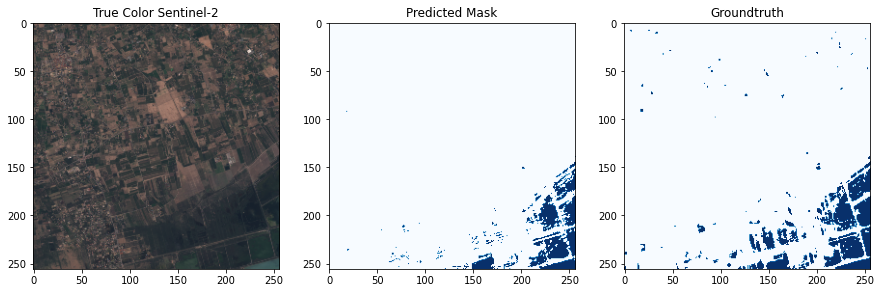

In [52]:
display_outputs()